# 10_ImageAlignement_Testing
In diesem Jupyter Notebook werden Statistiken und Visualisierungen aus Daten RMSE-Werten der Metashape-Reports generiert.

Die Daten basieren auf Bildern der DJI Mini 3 Pro 26.03.2025.

### Import der Libraries

In [1]:
import pandas as pd
import glob
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import laspy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import traceback

### Definition der Grundlagedaten

In [11]:
# CSV-Verzeichnis
csv_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\CSV"
print("Daten in CSV-Verzeichnis:", os.listdir(csv_dir))

# # PointCloud-Verzeichnis auf HDD
# pc_hdd_dir = "F:\\530_PointClouds_UAV"
# print("Daten in PointCloud-Verzeichnis (HDD):", os.listdir(pc_hdd_dir))

# PointCloud-Verzeichnis 
pc_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"
print("Daten in PointCloud-Verzeichnis:", os.listdir(pc_dir))


Daten in CSV-Verzeichnis: ['10_ImageAlignement_Testing.csv']
Daten in PointCloud-Verzeichnis: ['01_Generic_Preselection_source_guided_matching_NO_tree.las', '02_Generic_Preselection_estimated_guided_matching_NO_tree.las', '03_Generic_Preselection_source_guided_matching_YES_tree.las', '04_Generic_Preselection_estimated_guided_matching_YES_tree.las']


## 2. Analyse Punktwolken (clipped) 
Die Punkwolken werden aufgrund der Attribute analysiert, um eine Erkenntnis aus den verschiedenen Aufnahmedaten zu erhalten.

### 2.1 Histogramm der Confidence-Werte der Punktwolken in Kategorien
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "09_CraneCam_ZHAW_Copmparison\90_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Kategorie (1 - >12) werden die normierten Anteile pro Aufnahmedatum dargestellt.

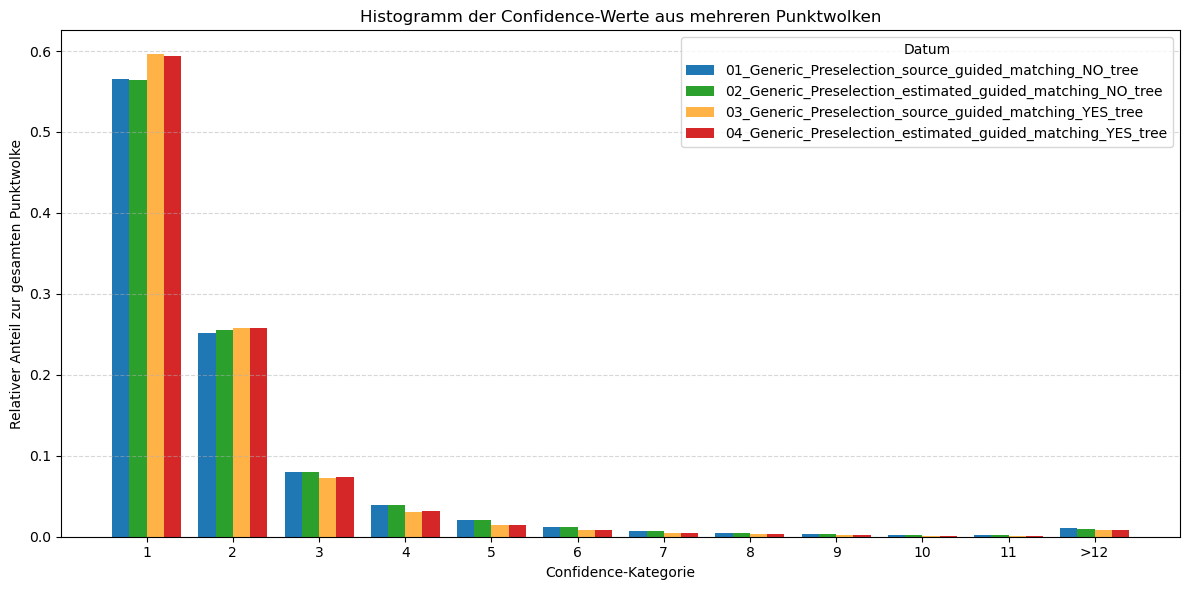

In [3]:
import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))

if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Bins definieren: 1–12, letzte Kategorie >12
bins = list(np.arange(1, 13)) + [np.inf]
bin_labels = [str(i) for i in range(1, 12)] + [">12"]

# Funktion zur Berechnung des normalisierten Histogramms der Confidence-Werte
def compute_confidence_histogram(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    confidence = las['confidence']
    counts, _ = np.histogram(confidence, bins=bins)
    total = np.sum(counts)
    norm_counts = counts / total if total > 0 else np.zeros_like(counts)
    return norm_counts

# Farbpalette (z. B. aus Tableau / Plotly / ColorBrewer etc.)
colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

# Histogramme berechnen und speichern
hist_data = []
labels = []

for idx, file in enumerate(las_files):
    try:
        hist = compute_confidence_histogram(file)
        hist_data.append(hist)
        # Optional: Nur das Datum aus dem Dateinamen extrahieren
        basename = os.path.basename(file)
        label = os.path.splitext(basename)[0]  # z.B. "20250224"
        labels.append(label)
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file}: {e}")

# Plot vorbereiten
x = np.arange(len(bin_labels))  # Positionen der Kategorien
width = 0.8 / len(hist_data)  # Balkenbreite dynamisch anpassen

fig, ax = plt.subplots(figsize=(12, 6))

# Für jede Datei Balken zeichnen
for i, (hist, label) in enumerate(zip(hist_data, labels)):
    offset = (i - len(hist_data)/2) * width + width/2
    ax.bar(x + offset, hist, width=width, label=label, color=colors[i % len(colors)])

# Achsen & Layout
ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel("Confidence-Kategorie")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der Confidence-Werte aus mehreren Punktwolken")
ax.legend(title="Datum")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


### 2.2 Histogramm der Confidence-Werte der Punktwolken (kontinuierlich)
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "10_ImageAlignement_Testing\100_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Wert werden die normierten Anteile pro Aufnahmedatum dargestellt.
Zudem werden noch die maximalen Confidence-Werte der einzelnen Aufnahmedaten auf dem Graphen dargestellt, da diese aufgrund der geringen Anzahl Punkte im Verhältnis zu anderen Werten, kaum erkennbar sind.

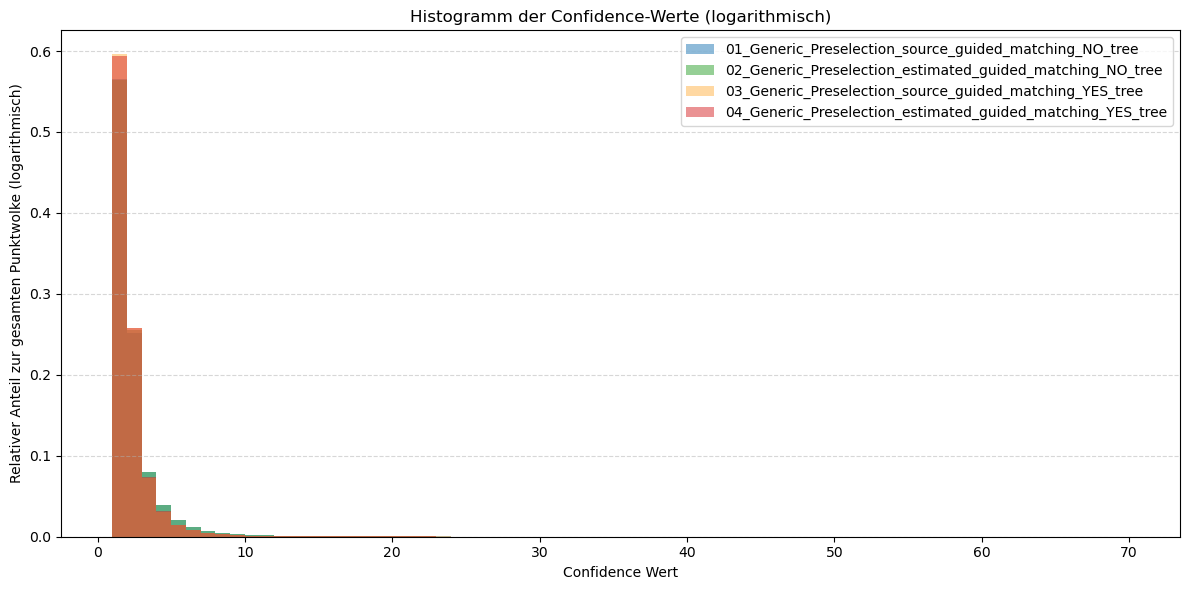

In [4]:
import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion zum Extrahieren der Confidence-Werte
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte aller Dateien sammeln
confidence_data = {}
min_vals, max_vals = [], []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamer Wertebereich für alle Histogramme
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(min_conf, max_conf, len_bins)

# Plot vorbereiten: logarithmisches Histogramm
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

for i, (file, conf) in enumerate(confidence_data.items()):
    label = os.path.splitext(os.path.basename(file))[0]
    ax.hist(conf, bins=bins, density=True, alpha=0.5, label=label, color=colors[i % len(colors)])

# Achsen und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte (logarithmisch)")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


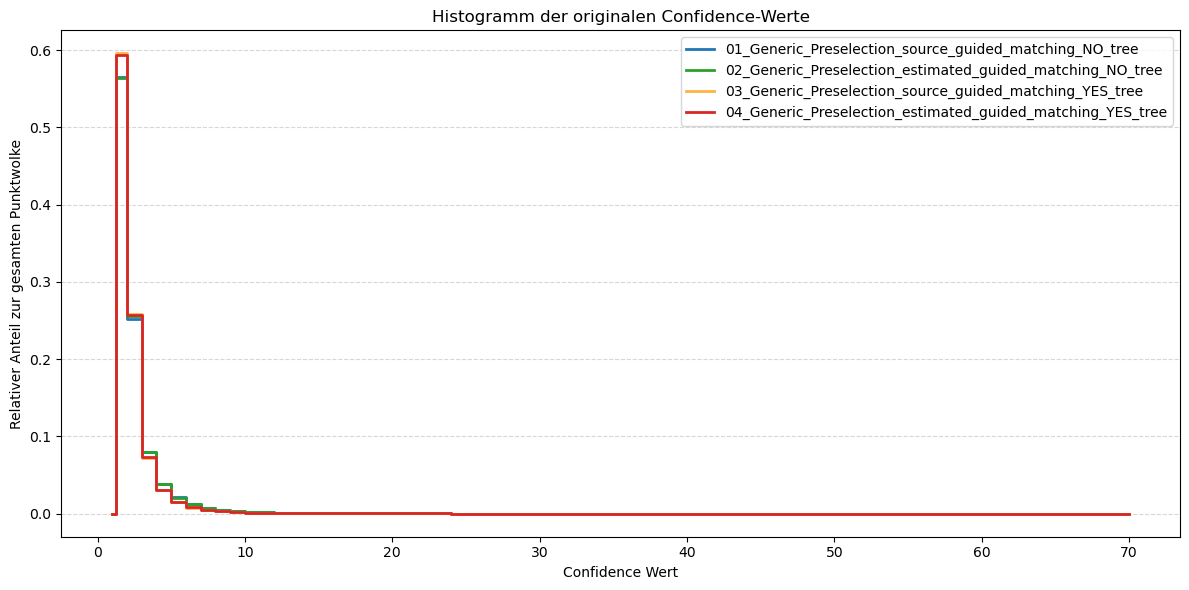

In [5]:
import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um Confidence-Werte zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Daten vorbereiten
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamen Wertebereich und Binning bestimmen
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(min_conf, max_conf, len_bins)

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]
annotations = []

for i, (file, conf) in enumerate(confidence_data.items()):
    hist, edges = np.histogram(conf, bins=bins, density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    x_ext = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
    y_ext = np.concatenate(([0], hist, [0]))
    
    label = os.path.splitext(os.path.basename(file))[0]
    ax.step(x_ext, y_ext, label=label, color=colors[i % len(colors)], linewidth=2, where="mid")
    
    annotations.append(f"{label}: {np.max(conf):.0f}")

# Achsen und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der originalen Confidence-Werte")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()


### 2.3 Histogramm der Confidence-Werte der Punktwolken mit einer logarithmischen Skala - normiert (kontinuierlich)
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "10_ImageAlignement_Testing\100_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Wert werden die normierten Anteile pro Aufnahmedatum in einer logarithsmischen Skala dargestellt.


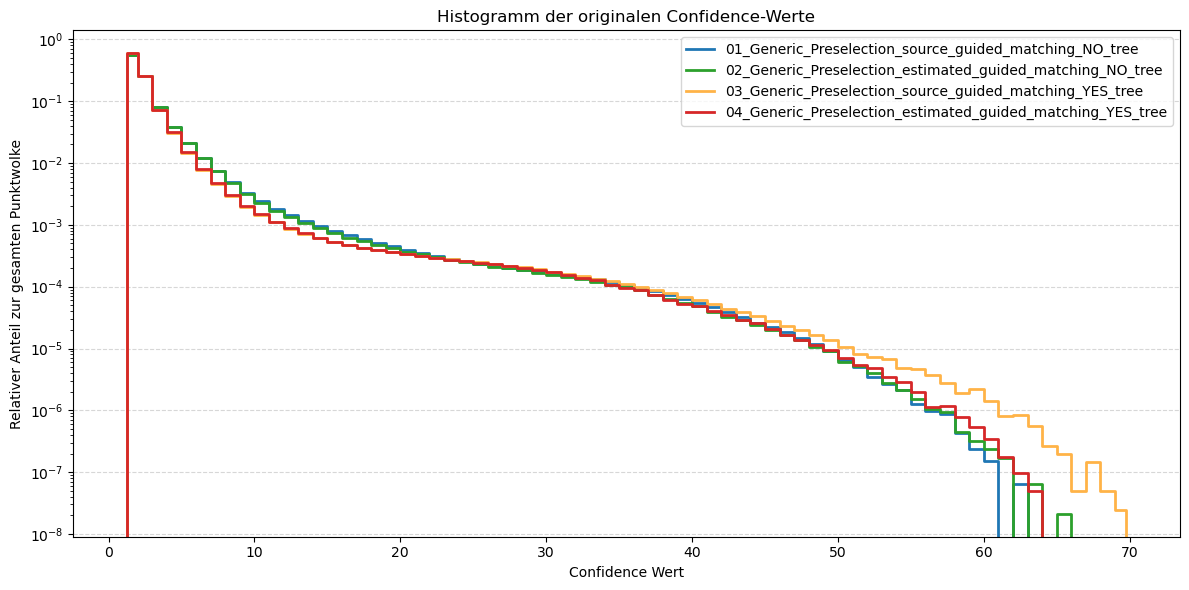

In [6]:
import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um Confidence-Werte zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Daten vorbereiten
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamen Wertebereich und Binning bestimmen
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(min_conf, max_conf, len_bins)

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]
annotations = []

for i, (file, conf) in enumerate(confidence_data.items()):
    hist, edges = np.histogram(conf, bins=bins, density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    x_ext = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
    y_ext = np.concatenate(([0], hist, [0]))
    
    label = os.path.splitext(os.path.basename(file))[0]
    ax.step(x_ext, y_ext, label=label, color=colors[i % len(colors)], linewidth=2, where="mid")
    
    annotations.append(f"{label}: {np.max(conf):.0f}")

# Achsen und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der originalen Confidence-Werte")
ax.set_yscale("log")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()


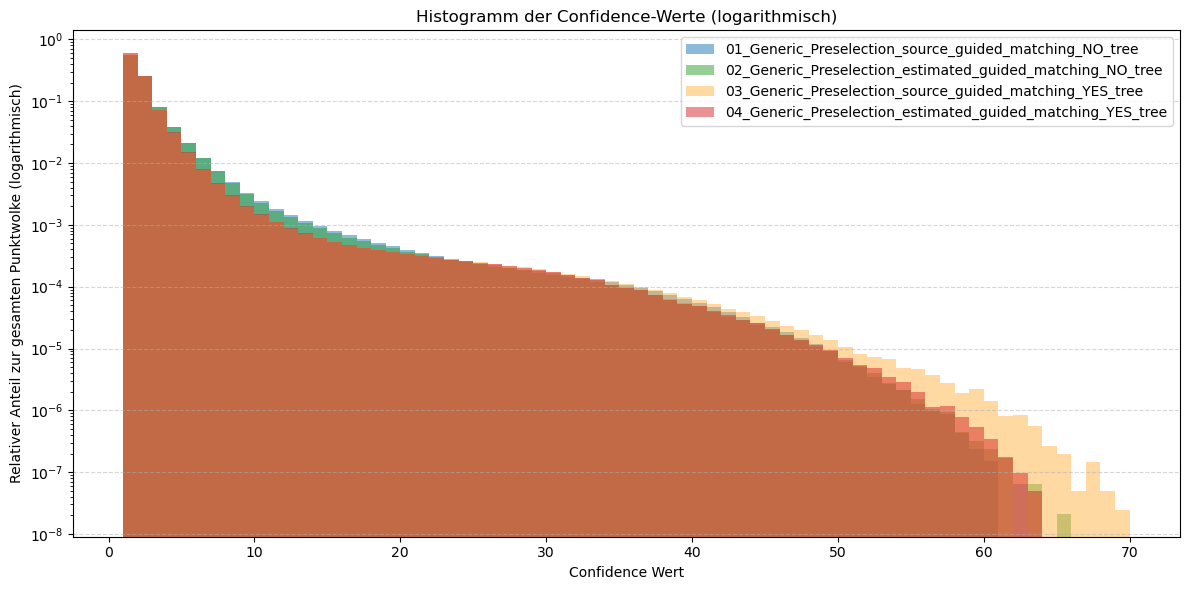

In [7]:
import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion zum Extrahieren der Confidence-Werte
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte aller Dateien sammeln
confidence_data = {}
min_vals, max_vals = [], []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamer Wertebereich für alle Histogramme
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(min_conf, max_conf, len_bins)

# Plot vorbereiten: logarithmisches Histogramm
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

for i, (file, conf) in enumerate(confidence_data.items()):
    label = os.path.splitext(os.path.basename(file))[0]
    ax.hist(conf, bins=bins, density=True, alpha=0.5, label=label, color=colors[i % len(colors)])

# Achsen und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte (logarithmisch)")
ax.set_yscale("log")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


### 2.4 Histogramm der Confidence-Werte der Punktwolken mit einer logarithmischen Skala - Anzahl Punkte(kontinuierlich)
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "10_ImageAlignement_Testing\100_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Wert werden die Anzahl Punkte pro Aufnahmedatum in einer logarithsmischen Skala dargestellt.


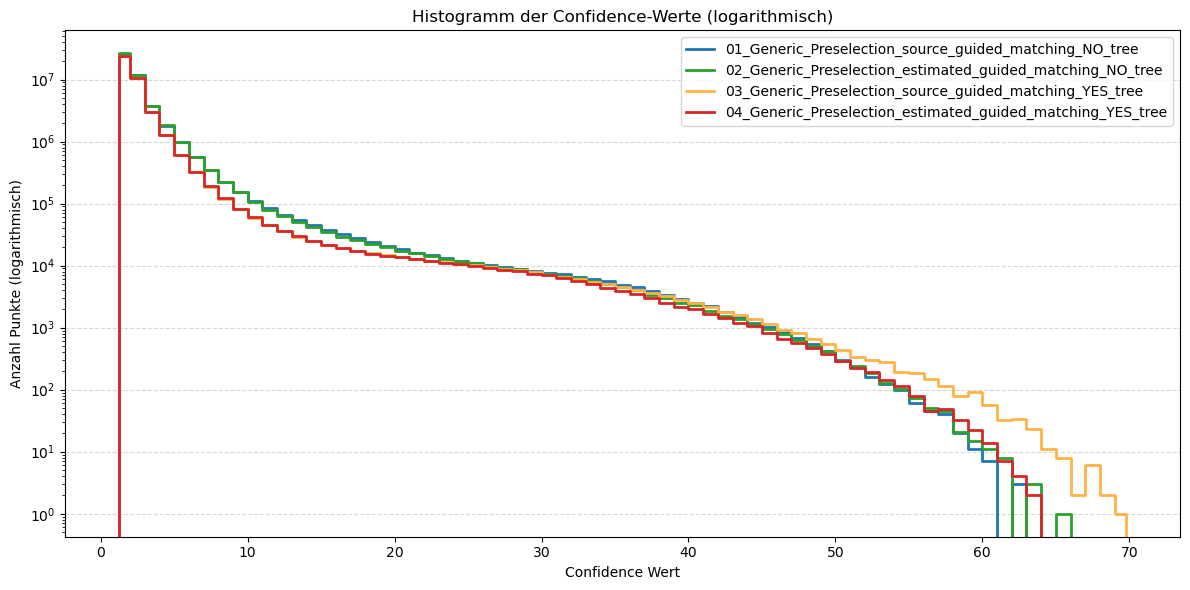

In [8]:
import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"

# Alle .las-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Daten vorbereiten
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsames Binning für alle Dateien
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(min_conf, max_conf, len_bins)

# Bin-Zentren berechnen
bin_centers = (bins[:-1] + bins[1:]) / 2
x_extended = np.concatenate(([bins[0]], bin_centers, [bins[-1]]))

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

# Für jede Datei das Histogramm berechnen und als Stufenplot darstellen
for i, (file, conf) in enumerate(confidence_data.items()):
    hist, _ = np.histogram(conf, bins=bins, density=False)
    y_extended = np.concatenate(([0], hist, [0]))
    label = os.path.splitext(os.path.basename(file))[0]
    ax.step(x_extended, y_extended, where="mid", label=label, linewidth=2, color=colors[i % len(colors)])

# Achsenbeschriftung & Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Anzahl Punkte (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte (logarithmisch)")
ax.set_yscale("log")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


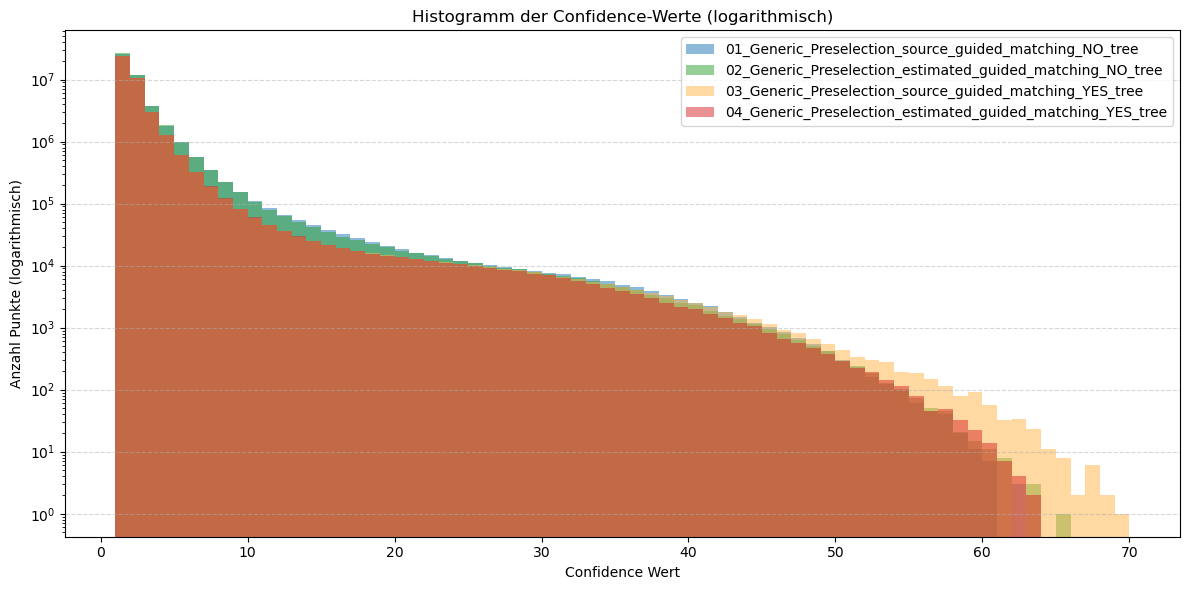

1


In [9]:
import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree"

# Alle .las-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte und Min/Max sammeln
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsames Binning
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(min_conf, max_conf, len_bins)

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

for i, (file, conf) in enumerate(confidence_data.items()):
    label = os.path.splitext(os.path.basename(file))[0]
    ax.hist(conf, bins=bins, alpha=0.5, label=label, color=colors[i % len(colors)])

# Achsenbeschriftung und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Anzahl Punkte (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte (logarithmisch)")
ax.set_yscale("log")  # Logarithmische y-Achse
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

hist, edges = np.histogram(conf, bins=bins)
print(min_conf)


In [12]:
# Überprüfen, ob das Verzeichnis existiert
if not os.path.exists(pc_dir):
    raise FileNotFoundError(f"Verzeichnis nicht gefunden: {pc_dir}")

# Liste aller LAS-Dateien im Ordner
las_files = [f for f in os.listdir(pc_dir) if f.lower().endswith(".las")]

# Für jede Datei wird die Anzahl der Punkte ermittelt und ausgegeben.
for filename in las_files:
    file_path = os.path.join(pc_dir, filename)
    las = laspy.read(file_path)
    # Anzahl der Punkte (als Länge des Arrays der Punktdaten)
    num_points = len(las.points)
    print(f"{filename}: {num_points} Punkte")

01_Generic_Preselection_source_guided_matching_NO_tree.las: 46557453 Punkte
02_Generic_Preselection_estimated_guided_matching_NO_tree.las: 47062844 Punkte
03_Generic_Preselection_source_guided_matching_YES_tree.las: 40942677 Punkte
04_Generic_Preselection_estimated_guided_matching_YES_tree.las: 40595132 Punkte
